# Predicting CLTV and Customer Repeat with Machine Learning for Shopify 

#### A Data Science Analysis Project by Benjamin N. Bellman 

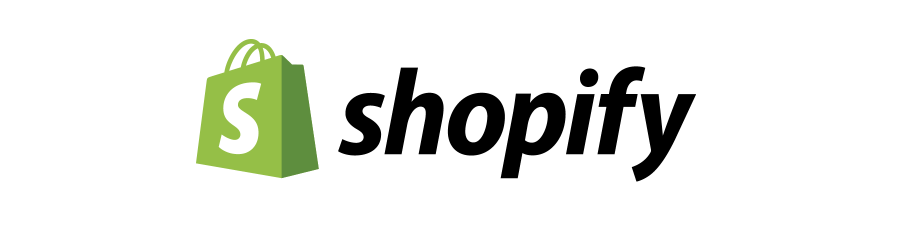

### Project Table of Contents: 
<br> 
    
**I. INTRODUCTION \& PRELIMINARY ANALYSIS**
- 1. Project Purpose 
- 2. Loading \& Previewing Data   
- 3. Data Wrangling  
- 4. Preliminary EDA 
 
**II. DATA WRANGLING**  
- 1. Cleaning up data. 
- 2. Creating 3 separate dataframes.
- 3. Creating the final 1 year CLTV Table.

**III. EXPLORATORY DATA ANALYSIS**     
- 1. Loading an Previewing the New Table  
- 2. Exploring relationships of variables on Post First Week Spend 

**IV. PREPROCESSING AND MODELLING**
- 1. Linear Models
- 2. Classification Models


## Part 3: PreProcessing and Modelling

### Loading our Packages and DataFrame

In [1]:
## We start by importing the packages we will use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae, f1_score, fbeta_score 
from sklearn.metrics import plot_confusion_matrix,classification_report, balanced_accuracy_score, recall_score

from io import StringIO 
from IPython.display import Image  
import pydotplus
import graphviz

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
## We Load and preview our customer_cltv dataframe from the previouse chapter 
customer_cltv = pd.read_csv('.\..\cleaned_data.csv',index_col=0)
customer_cltv.head()

,CustomerID,pfw_spent,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range
0,Anonymous13455,1257.80,1,1,50.0,0,6,0,M,0,0,MW,high
1,Anonymous2142,436.15,1,1,48.0,0,5,0,L,0,0,NE,high
2,Anonymous4843,1052.75,2,2,96.0,0,10,0,S,1,0,W,high
3,Anonymous11225,728.10,1,1,16.0,0,1,1,No size,0,0,MW,low
4,Anonymous540,1114.75,1,1,50.0,0,1,0,XS,0,0,W,high


## Preprocessing: 

In [3]:
## Drop some error rows (no spending on the first week)
customer_cltv = customer_cltv[customer_cltv.loc[:,'fw_total_spent'] > 0] 

## Drop all non-repeat customers
#customer_cltv_drop = customer_cltv_drop[customer_cltv.loc[:,'pfw_spent'] > 0]

<br> **Drop variables that we found to be heavily correlated with other or irrelevant through the previous step of EDA**
- **fw_nb_items** is highly correlated with fw_total_spent (c=0.94)
- **fw_nb_orders** is very unbalanced (~ 95% customers only made 1 order the first week)
- **region** was found to be insignificant based on several steps of statistical analysis
- **fw_purchased_accessory** is logically redundant with first_item_size


In [4]:
customer_cltv.drop(columns=['fw_nb_items', 'region', 'fw_nb_orders', 'fw_purchased_accessory'], inplace = True)

<br> **Modify variables based on findings from EDA**
- **first_order_month** can be modified to be 2 categories: February-June vs rest of the year
- **first_item size** can be modified to be 2 categories: Large Size and Smaller Sizes

In [5]:
## First Item Month 
customer_cltv['first_order_feb_june'] = customer_cltv['first_order_month'].apply(lambda x: x in [2, 3, 4, 5, 6])
customer_cltv['first_order_feb_june'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_order_month'], inplace = True)

## First Item Size: 
customer_cltv['large_size'] = customer_cltv['first_item_size'].apply(lambda x: x in ['XL','L','M'])
customer_cltv['large_size'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_item_size'], inplace = True)
customer_cltv.head()

,CustomerID,pfw_spent,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_item_price_range,first_order_feb_june,large_size
0,Anonymous13455,1257.80,50.0,0,0,0,high,1,1
1,Anonymous2142,436.15,48.0,0,0,0,high,1,1
2,Anonymous4843,1052.75,96.0,0,1,0,high,0,0
3,Anonymous11225,728.10,16.0,0,0,0,low,0,0
4,Anonymous540,1114.75,50.0,0,0,0,high,0,0


#### We create dummy variables for our categorical variables.

In [6]:
## We create dummy variables for prize range of items. 
categorical_cols = ['first_item_price_range']
dummies_encoded = pd.get_dummies(customer_cltv[categorical_cols].astype(str),drop_first=True)
customer_cltv = pd.concat([customer_cltv,dummies_encoded], axis =1)
customer_cltv.drop(columns=['first_item_price_range'],inplace = True)
customer_cltv.head()

,CustomerID,pfw_spent,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,Anonymous13455,1257.80,50.0,0,0,0,1,1,0,0
1,Anonymous2142,436.15,48.0,0,0,0,1,1,0,0
2,Anonymous4843,1052.75,96.0,0,1,0,0,0,0,0
3,Anonymous11225,728.10,16.0,0,0,0,0,0,1,0
4,Anonymous540,1114.75,50.0,0,0,0,0,0,0,0


In [7]:
## We get our feature variables and target variables
X = customer_cltv.drop(columns=['CustomerID','pfw_spent'])
y = customer_cltv['pfw_spent']
print(X.shape, y.shape)

(10590, 8) (10590,)


In [8]:
## We use a scaler to scale the feature variables which are not categorical: 
cols_to_scale = ['fw_total_spent']
scaler = StandardScaler()
scaler.fit(X[cols_to_scale])

X_scaled = scaler.transform(X[cols_to_scale])
for ind, col in enumerate(cols_to_scale):
    X[col] = X_scaled[:,ind]
X.head()

,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,-0.347324,0,0,0,1,1,0,0
1,-0.389530,0,0,0,1,1,0,0
2,0.623424,0,1,0,0,0,0,0
3,-1.064833,0,0,0,0,0,1,0
4,-0.347324,0,0,0,0,0,0,0


In [9]:
## We split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7942, 8) (2648, 8) (7942,) (2648,)


In [28]:
## We create a new table and add a new target variable: pfw_return
customer_cltv_cls = customer_cltv_drop
customer_cltv_cls['pfw_return'] = np.where(customer_cltv_cls['pfw_spent'] > 0,1,0)

## We recreate the dummy variables and drop the original columns
categorical_cols = ['first_item_size','first_item_price_range']
dummies_encoded = pd.get_dummies(customer_cltv_cls[categorical_cols].astype(str),drop_first=True)
customer_cltv_encoded = pd.concat([customer_cltv_cls,dummies_encoded], axis =1)
customer_cltv_encoded.drop(columns=['first_item_size','first_item_price_range','pfw_spent'],inplace = True)

## We preview the amount of post first week customers and the first few rows of our new dataframe.
print('Distribution of PFW repeat: ')
print(customer_cltv_encoded.pfw_return.value_counts())
print("\n")
print('Proportion of Post First Week Repeat Customers: ' + str(round(customer_cltv_drop[customer_cltv_drop['pfw_spent'] > 0]['pfw_spent'].count() 
                                                               / customer_cltv_drop['pfw_spent'].count(),2)))
customer_cltv_encoded.head()

NameError: name 'customer_cltv_drop' is not defined

In [ ]:
## We recreate our target and feature variables which we will feed into different models and print their shape.
X = customer_cltv_encoded.drop(columns=['CustomerID','pfw_return'])
y = customer_cltv_encoded['pfw_return']
print(X.shape,y.shape)
X.head()

In [ ]:
## We split the data in training and testing sets.
X_train, X_test , y_train, y_test = train_test_split(X,y, test_size =0.25, random_state =1234)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

## Logistic Regression 

In [ ]:
## We instantiate a logistic regression model and use GridSearchCV to find the best parameters. 
'''
log_reg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'l1_ratio': [0,.5,1]
             }
lr_cv = GridSearchCV(log_reg, param_grid, cv=10, scoring='roc_auc')
lr_cv.fit(X,y)
lr_cv.best_estimator_
'''
# We get the result: 'LogisticRegression(C=10, l1_ratio=0) '

In [ ]:
## With the best parameters, we re-instantiate the model, fit and predict the probabilities. 
log_reg = LogisticRegression(C=10)
log_reg.fit(X_train, y_train)

## We predict the probabilities of s
y_pred = log_reg.predict(X_test)
y_pred = pd.Series(y_pred)

## We visualize the prediction that the Logistic Regression Gives us. 
y_pred.value_counts()

In [ ]:
y_pred = log_reg.predict_proba(X_test)[:,1]
log_fpr, log_tpr, threshold = roc_curve(y_test,y_pred)
log_auc = auc(log_fpr, log_tpr)
print(log_auc)

## Random Forests:

In [ ]:
# We instantiate the RandomForestClassifier and use GridSearch for best hyperparameters
'''
rfc = RandomForestClassifier(random_state = 1234)
param_grid = { 
    'n_estimators': [10, 25, 50, 75, 100],
    'max_features': [None, 'auto', 'log2'],
    'max_depth' : list(range(0,10)),
}
rfc_cv = GridSearchCV(rfc, param_grid, cv=10, scoring='roc_auc')

rfc_cv.fit(X,y)
rfc_cv.best_estimator_
'''
## The findings for the above cell (if all customers) is: ' RandomForestClassifier(max_depth=4, n_estimators=10) '
## The findings for the above cell (if pfw > 0 ) is: ' RandomForestClassifier(max_depth=10, n_estimators=25) '

In [ ]:
## With the best parameters, we re-instantiate the model, fit and predict the probabilities. 
rfc = RandomForestClassifier(max_depth=4, n_estimators=10)
rfc.fit(X_train, y_train)

y_pred = rfc.predict_proba(X_test)[:,1]
y_predict = rfc.predict(X_test)
y_predict

In [ ]:
rfc_fpr, rfc_tpr, threshold = roc_curve(y_test, y_pred)
auc_rfc = auc(rfc_fpr, rfc_tpr)
print(auc_rfc)

In [ ]:
## We visualize the feature importance for the Random Forest Model
fi_rfc = pd.DataFrame(rfc.feature_importances_, index = X_train.columns, 
                      columns=['importance']).sort_values('importance', ascending=False)
fi_rfc

In [ ]:
## We plot the visualization importance. 
plt.plot(fi_rfc.importance)
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
plt.title('Most important Features', pad =25)
plt.show()

In [ ]:
## We plot the ROC and visualize the AUC of our classification models
fig, heat = plt.subplots(figsize = (15,15))
plt.plot(rfc_fpr, rfc_tpr, marker='.', color='green', label='Random Forest %f' % auc_rfc)
plt.plot(log_fpr, log_tpr, marker='.', color='red', label='Logistic Regression %f' % log_auc)

# We plot a line that goes shows when FPR = TPR
lims = [np.min([0.0, 0.0]),  
        np.max([1.0, 1.0])]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, c='b', linestyle ='--')

## We label the axes and give a title. 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Classification Models', pad =25)
plt.legend()
plt.savefig('auc_comp.png')
plt.show()